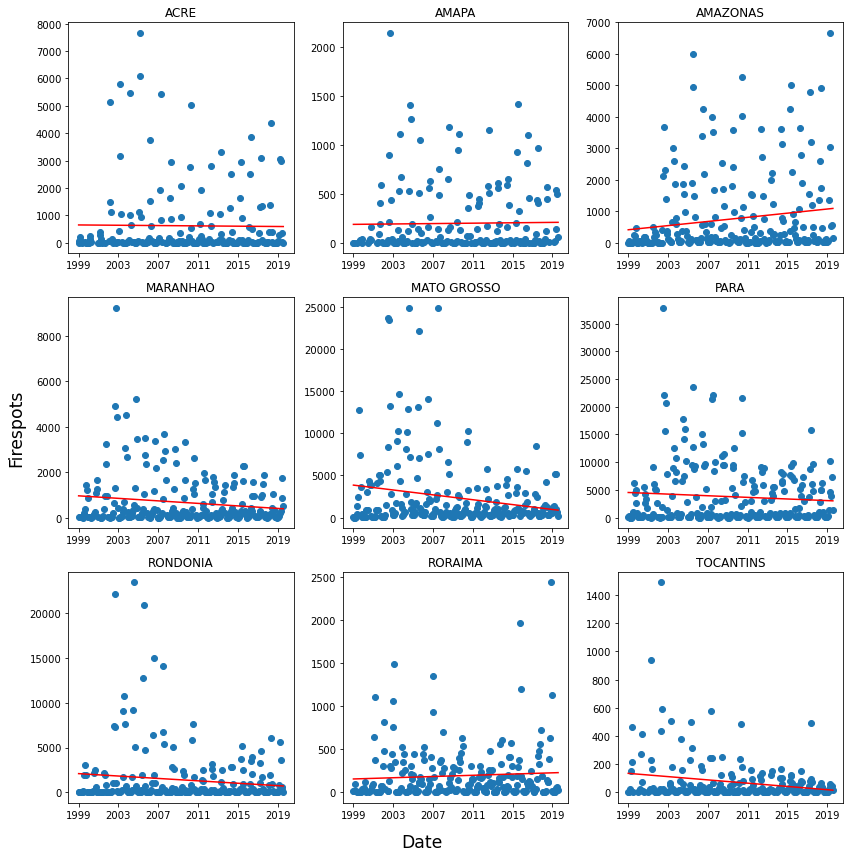

In [1]:
# Dan Hoogasian
# Final Project
# Rainforest Deforestation

import math
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Read in data 
data = pd.read_csv("./inpe_brazilian_amazon_fires_1999_2019.csv", header = 0)
df = data.copy()
df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1)).apply(lambda z: z.value)

df = df[['year', 'month', 'date', 'state', 'latitude', 'longitude', 'firespots']]

# Group data by state and create scatterplot matrix for each state
grouped_by_state = df.groupby("state")

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i, (group_name, group_data) in enumerate(grouped_by_state):
    row = i // 3
    col = i % 3
    
    x = group_data['date']#.apply(lambda z: z.value)
    y = group_data['firespots']
    
    axs[row, col].scatter(x, y)
    axs[row, col].set_title(group_name)
    
    m, b = np.polyfit(x, y, 1)
    axs[row, col].plot(x, m*x + b, color='red')
    start = int(x.iloc[0])
    stop = int(x.iloc[-1])
    diff = int((stop - start)/6)
    range_diff = int((diff*7)/6)
    stop_range = (stop + range_diff)
    axs[row, col].set_xticks(range(start, stop, range_diff),
                             ['1999', '2003', '2007', '2011', '2015', '2019'])

fig.supxlabel('Date', fontsize = 'xx-large')
fig.supylabel('Firespots', fontsize = 'xx-large')
fig.tight_layout()
plt.show()

In [2]:
# Calculate correlation coefficients
print("Correlations: ")
for i, (group_name, group_data) in enumerate(grouped_by_state):
    row = i // 3
    col = i % 3
    
    x = group_data['date']
    y = group_data['firespots']
    correlation = np.corrcoef(x,y)[0][1]
    print(group_name, " ", round(correlation, 2))
    
# Combining data for all states
X_total = df['date'].unique()
total_firespots = df.groupby("date")['firespots'].sum()

totals_df = pd.DataFrame(total_firespots)
Y_total = totals_df.iloc[:, 0]

Correlations: 
ACRE   -0.01
AMAPA   0.02
AMAZONAS   0.15
MARANHAO   -0.14
MATO GROSSO   -0.21
PARA   -0.08
RONDONIA   -0.12
RORAIMA   0.07
TOCANTINS   -0.22


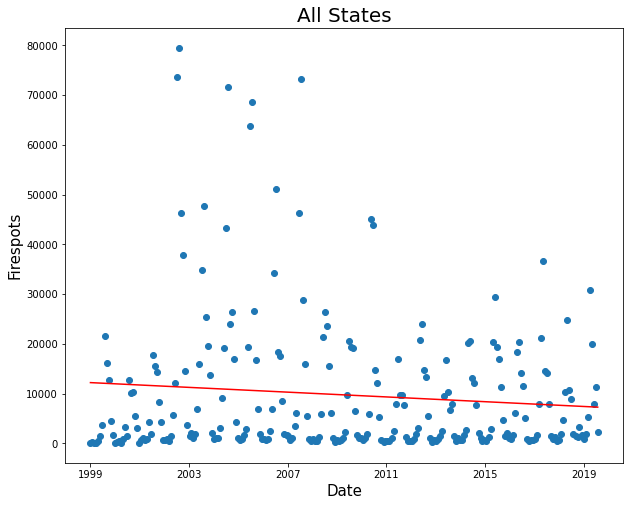

Correlation:  -0.1


In [3]:
# Scatterplot of total firespots
plt.figure(figsize=(10,8))
plt.scatter(X_total, Y_total)
m, b = np.polyfit(X_total, Y_total, 1)
plt.plot(X_total, m*X_total + b, color='red')
start = int(X_total[0])
stop = int(X_total[-1])
diff = int((stop - start)/6)
range_diff = int((diff*7)/6)
plt.xticks(range(start, stop, range_diff), 
                         ['1999', '2003', '2007', '2011', '2015', '2019'])
plt.title('All States', size = 20)
plt.xlabel('Date', size = 15)
plt.ylabel('Firespots', size = 15)

plt.show()
# Correlation
print("Correlation: ", round(np.corrcoef(X_total, Y_total)[0][1], 2))

RMSE:  15457.65


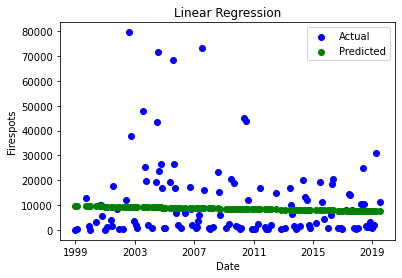

In [4]:
# Run supervised ML algorithms on past data and calculate root mean squared error to measure performance 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = X_total.copy()
Y = Y_total.copy()


# Linear regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.5)

weights = np.polyfit(X_train,Y_train, 1)
model = np.poly1d(weights)
predicted = model(X_test)
rmse1 = np.sqrt(mean_squared_error(Y_test, predicted))
print("RMSE: ", round(rmse1, 2))

# Plot actual vs. predicted values
plt.scatter(X_test, Y_test, color = "blue")
plt.scatter(X_test, predicted, color = "green")
start = int(X_total[0])
stop = int(X_total[-1])
diff = int((stop - start)/6)
range_diff = int((diff*7)/6)
plt.xticks(range(start, stop, range_diff), 
                         ['1999', '2003', '2007', '2011', '2015', '2019'])
plt.legend(['Actual', 'Predicted'])
plt.title('Linear Regression')
plt.xlabel('Date')
plt.ylabel('Firespots')
plt.show()  

RMSE:  12641.63


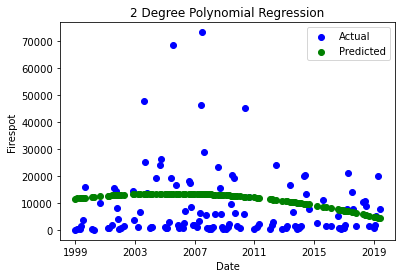

In [5]:
# Quadratic regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.5)

weights = np.polyfit(X_train,Y_train, 2)
model = np.poly1d(weights)
predicted = model(X_test)
rmse2 = np.sqrt(mean_squared_error(Y_test, predicted))
print("RMSE: ", round(rmse2, 2))

# Plot actual vs. predicted values
plt.scatter(X_test, Y_test, color = "blue")
plt.scatter(X_test, predicted, color = "green")
start = int(X_total[0])
stop = int(X_total[-1])
diff = int((stop - start)/6)
range_diff = int((diff*7)/6)
plt.xticks(range(start, stop, range_diff), 
                         ['1999', '2003', '2007', '2011', '2015', '2019'])
plt.legend(['Actual', 'Predicted'])
plt.title('2 Degree Polynomial Regression')
plt.xlabel('Date')
plt.ylabel('Firespot')
plt.show()  

Optimal value of k:  3 
RMSE of optimal k value:  17678.75


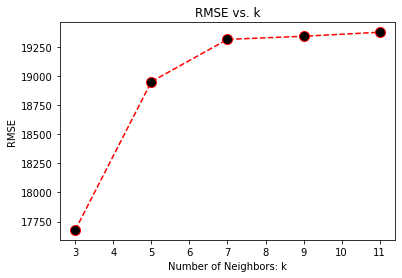

In [6]:
# k-NN
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.5)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

rmse_list = []
k_list = [3, 5, 7, 9, 11]
for k in k_list:
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    knn_classifier.fit(X_train, Y_train)
    predicted = knn_classifier.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(Y_test, predicted)))
min_rmse3, k_of_min_rmse = min(rmse_list), k_list[np.argmin(rmse_list)]    
print("Optimal value of k: ", k_of_min_rmse, "\nRMSE of optimal k value: ", round(min_rmse3, 2))

# Plot rmse of each k-value
plt . plot ([3, 5, 7, 9, 11], rmse_list , color ='red', linestyle ='dashed',
    marker ='o', markerfacecolor ='black', markersize =10)
plt . title ('RMSE vs. k')
plt . xlabel ('Number of Neighbors: k')
plt . ylabel ('RMSE')
plt.show()

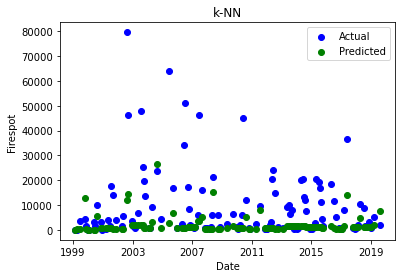

In [7]:
# Recalculate predicted values with optimal k-value
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.5)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

knn_classifier = KNeighborsClassifier(n_neighbors = k_of_min_rmse)
knn_classifier.fit(X_train, Y_train)
predicted = knn_classifier.predict(X_test)

# Plot actual vs. predicted values
plt.scatter(X_test, Y_test, color = "blue")
plt.scatter(X_test, predicted, color = "green")
start = int(X_total[0])
stop = int(X_total[-1])
diff = int((stop - start)/6)
range_diff = int((diff*7)/6)
plt.xticks(range(start, stop, range_diff), 
                         ['1999', '2003', '2007', '2011', '2015', '2019'])
plt.legend(['Actual', 'Predicted'])
plt.title('k-NN')
plt.xlabel('Date')
plt.ylabel('Firespot')
plt.show() 

In [8]:
# Determine best model
models = ["Linear Regression", "Quadratic Regression", "k-NN"]
min_rmse = np.argmin([rmse1, rmse2, min_rmse3])
print("Best Model and its RMSE: ", models[min_rmse], round(min(rmse1, rmse2, min_rmse3), 2))

Best Model and its RMSE:  Quadratic Regression 12641.63


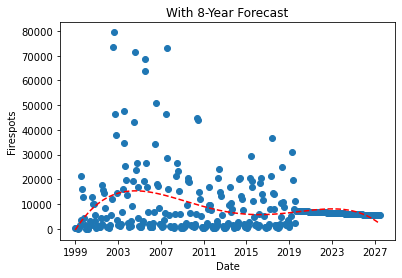

In [9]:
from scipy.optimize import curve_fit

# Create independent variable for predictions
future_str = []
for i in ['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027']:
    for j in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
        future_str.append(i + "-" + j + "-01")
X2 = np.array(pd.to_numeric(pd.to_datetime(future_str)))

# Use best model (linear regression) to estimate projected values until 2027
weights = np.polyfit(X,Y, 1)
model = np.poly1d(weights)
predicted = model(X2)

# Plot predicted dates & values

all_X = np.concatenate((X, X2))
all_Y = np.concatenate((Y, predicted))

# Create polynomial equation of line, to plot line of best fit
def objective(x, a, b, c, d, e):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + e
 
popt, _ = curve_fit(objective, all_X, all_Y)
a, b, c, d, e = popt

plt.scatter(all_X, all_Y)

# define a sequence of inputs between the smallest and largest known inputs
X_line = np.linspace(min(all_X), max(all_X), 1000)
Y_line = objective(X_line, a, b, c, d, e)

plt.plot(X_line, Y_line, '--', color='red')
start = int(all_X[0])
stop = int(all_X[-1])
diff = int((stop - start)/8)
range_diff = int((diff*9)/8)
stop_range = (stop + range_diff)
plt.xticks(range(start, stop, range_diff), 
                         ['1999', '2003', '2007', '2011', '2015', '2019', '2023', '2027'])
plt.title('With 8-Year Forecast')
plt.xlabel('Date')
plt.ylabel('Firespots')
plt.show()

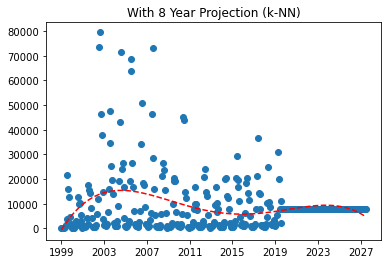

In [10]:
# Use k-NN to estimate projected values until 2027
X2_1d = np.array(pd.to_numeric(pd.to_datetime(future_str)))
X2 = X2_1d.reshape(-1,1)
predicted = knn_classifier.predict(X2)

# Plot predicted dates & values (for k-NN)
all_X = np.concatenate((X, X2_1d))
all_Y = np.concatenate((Y, predicted))

# Create polynomial equation of line, to plot line of best fit
def objective(x, a, b, c, d, e):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + e
 
popt, _ = curve_fit(objective, all_X, all_Y)
a, b, c, d, e = popt

plt.scatter(all_X, all_Y)

# define a sequence of inputs between the smallest and largest known inputs
X_line = np.linspace(min(all_X), max(all_X), 1000)
Y_line = objective(X_line, a, b, c, d, e)

plt.plot(X_line, Y_line, '--', color='red')
start = int(all_X[0])
stop = int(all_X[-1])
diff = int((stop - start)/8)
range_diff = int((diff*9)/8)
stop_range = (stop + range_diff)
plt.xticks(range(start, stop, range_diff), 
                         ['1999', '2003', '2007', '2011', '2015', '2019', '2023', '2027'])
plt.title('With 8 Year Projection (k-NN)')
plt.show()

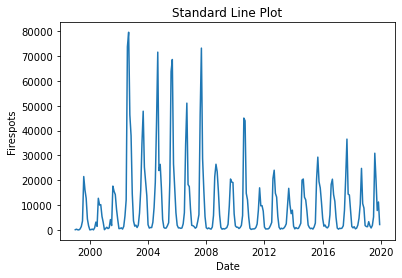

In [11]:
# Create column for time series forecasting & plot
df['date_ts'] = pd.to_datetime(dict(year=df.year, month=df.month, day=1))
X_total_ts = df['date_ts'].unique()
total_firespots_ts = df.groupby('date_ts')['firespots'].sum()

totals_df_ts = pd.DataFrame(total_firespots_ts)
Y_total_ts = totals_df_ts.iloc[:, 0]

plt.plot(totals_df_ts)
plt.title('Standard Line Plot')
plt.xlabel('Date')
plt.ylabel('Firespots')
plt.show()

In [12]:
# Split data into test/train for simple moving average forecasting and calculate RMSE
my_data = totals_df_ts.copy()

train_len = math.floor(len(my_data)*.5) # 50% or roughly 126
train = my_data[0:train_len]
test = my_data[train_len:]

my_data['sma_forecast'] = my_data['firespots'].rolling(window=10).mean()
my_data['sma_forecast'][train_len:] = my_data['sma_forecast'][train_len-1]

rmse = np.sqrt(mean_squared_error(test['firespots'], my_data['sma_forecast'][train_len:])).round(2)
print("RMSE: ", round(rmse, 2))

RMSE:  9117.15


In [13]:
# Autoregression forecasting and RMSE
from statsmodels.tsa.ar_model import AutoReg
my_data = totals_df_ts.copy()

train_len = math.floor(len(my_data)*.5) # 50% roughly 126
train = my_data[0:train_len]
test = my_data[train_len:]

model = AutoReg(train, lags=20) # lags set number of previous observations taken into account
model_fit = model.fit()
forecast = model_fit.forecast(steps=(math.ceil(len(my_data)*.5)))

rmse = np.sqrt(mean_squared_error(test['firespots'], forecast))
print("RMSE: ", round(rmse, 2))

RMSE:  8558.56


C:\Users\dhoog\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


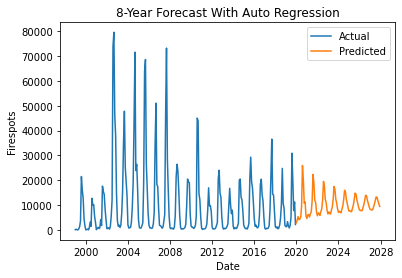

In [23]:
# Fit autoregression model on entire dataset & plot
model = AutoReg(totals_df_ts, lags=20)
model_fit = model.fit()
forecast = model_fit.forecast(steps=(8*12))

plt.plot(totals_df_ts, label='Actual')
plt.plot(forecast, label='Predicted')
plt.title('8-Year Forecast With Auto Regression')
plt.xlabel('Date')
plt.ylabel('Firespots')
plt.legend()
plt.show()

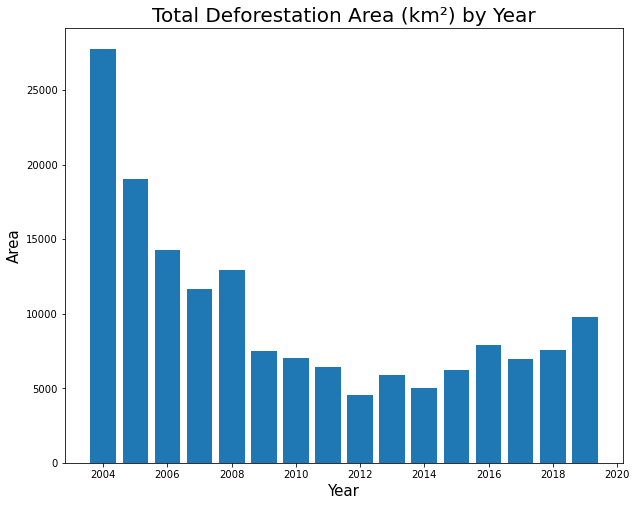

In [15]:
# Read in second dataset
data2 = pd.read_csv("./def_area_2004_2019.csv", parse_dates=True, encoding = "cp1252")
data2.rename({'ï»¿Ano/Estados':'Year','AC':'Acre','AM': 'Amazonas','AP': 'Amapa','MA':'Maranhao','MT':'Mato Grosso',
    'PA':'Para','RO':'Rondonia','RR':'Roraima','TO':'Tocantins','AMZ LEGAL':'Total'},
             axis=1, inplace=True)

# Plot total deforestation area by year
plt.figure(figsize=(10,8))
fig = plt.bar(data2['Year'], data2['Total'])

plt.title('Total Deforestation Area (km²) by Year', size = 20)
plt.xlabel('Year', size = 15)
plt.ylabel('Area', size = 15)
plt.show()

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

data = df.copy()
data.rename(columns={'firespots':'data'}, inplace=True)

ADF Statistic: -7.690305314496812
p-value: 1.4251078929922761e-11


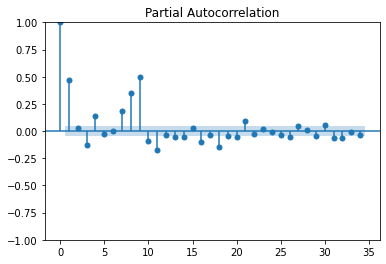

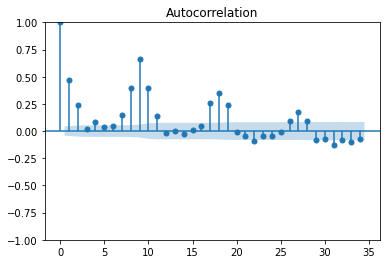

In [17]:
plot_pacf(data['data']);
plot_acf(data['data']);
ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

In [18]:
'''
Code adapted from:

Title: Time Series Forecast in Python
Retrievel Date: 5/3/2023 
Source: https://towardsdatascience.com/how-to-predict-your-step-count-for-next-week-a16b7800b408
'''
# Define the p, d and q parameters for value between 0-3 and iterate for all the value in the range
# This is timely
p = d = q = range(0, 2)
pdq = list(product(p, d, q))
# Generate all different combinations of seasonal p, q and q 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]
params=[]
seasonal=[]
aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = SARIMAX(train,order=param, seasonal_order=param_seasonal,                                    
        enforce_stationarity=False, enforce_invertibility=False)
        #append all the parameters and result AIC value
        results = mod.fit()
        params.append(param)
        seasonal.append(param_seasonal)
        aic.append(results.aic)
parameter_options=pd.DataFrame({'params':params,'seasonal_params':seasonal,'AIC':aic})
#sort the AIC value to find the best fitted model
parameter_options.sort_values(by='AIC')

,params,seasonal_params,AIC
107,"(0, 1, 0)","(2, 2, 2, 12)",1577.704587
485,"(1, 2, 2)","(2, 2, 2, 12)",1608.860387
728,"(2, 2, 2)","(2, 2, 2, 12)",1610.619538
161,"(0, 1, 2)","(2, 2, 2, 12)",1610.847199
242,"(0, 2, 2)","(2, 2, 2, 12)",1611.008585
...,...,...,...
243,"(1, 0, 0)","(0, 0, 0, 12)",2727.479177
27,"(0, 0, 1)","(0, 0, 0, 12)",2739.708120
405,"(1, 2, 0)","(0, 0, 0, 12)",2751.150774
162,"(0, 2, 0)","(0, 0, 0, 12)",2760.511250


In [19]:
# Fit SARIMA model on entire dataset
model = SARIMAX(train, order=(1,1,1), seasonal_order=(2,2,2,12),                                    
        enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()
forecast = model_fit.forecast(steps=(math.ceil(len(my_data)*.5)))

rmse = np.sqrt(mean_squared_error(test['firespots'], forecast))
print("RMSE of SARIMA: ", round(rmse, 2))

RMSE of SARIMA:  8519.81


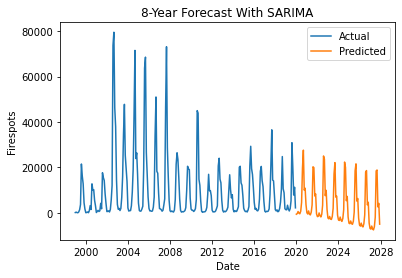

In [22]:
model = SARIMAX(totals_df_ts, order=(1,1,1), seasonal_order=(2,2,2,12),                                    
        enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()

forecast = model_fit.forecast(steps=(8*12))

plt.plot(totals_df_ts, label='Actual')
plt.plot(forecast, label='Predicted')
plt.title('8-Year Forecast With SARIMA')
plt.xlabel('Date')
plt.ylabel('Firespots')
plt.legend()
plt.show()

In [21]:
best_model = SARIMAX(totals_df_ts, order=(1, 1, 1), seasonal_order=(2, 2, 2, 12)).fit()
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                               firespots   No. Observations:                  252
Model:             SARIMAX(1, 1, 1)x(2, 2, [1, 2], 12)   Log Likelihood               -2362.210
Date:                                 Sat, 06 May 2023   AIC                           4738.420
Time:                                         19:01:18   BIC                           4762.395
Sample:                                     01-01-1999   HQIC                          4748.094
                                          - 12-01-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9442      0.280     -3.377      0.001      -1.492      -0